In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 로드

In [2]:
df = pd.read_csv('./train.csv')
df['시점'] = pd.to_datetime(df['시점'], format='%Y-%m-%d %H')
df.set_index('시점', inplace=True)
df

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


In [3]:
test = pd.read_csv('./test.csv')
test['시점'] = pd.to_datetime(test['시점'], format='%Y-%m-%d %H')
test.set_index('시점', inplace=True)
test

,구분
시점,
2019-01-01 00:00:00,A
2019-01-01 01:00:00,A
2019-01-01 02:00:00,A
2019-01-01 03:00:00,A
2019-01-01 04:00:00,A
...,...
2019-03-31 19:00:00,H
2019-03-31 20:00:00,H
2019-03-31 21:00:00,H


# 구분=D, hour=0 데이터 학습

In [4]:
# 구분=D, hour=0인 데이터 추출
df_D0 = df[(df['구분'] == 'D') & (df.index.hour == 0)]
df_D0.drop(columns='구분', inplace=True)
df_D0

,공급량
시점,
2013-01-01,1434.516
2013-01-02,1291.316
2013-01-03,1664.996
2013-01-04,1688.276
2013-01-05,1695.316
...,...
2018-12-27,1330.120
2018-12-28,1571.524
2018-12-29,1574.356


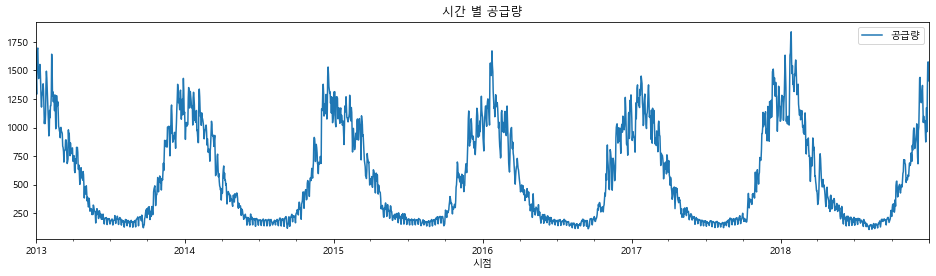

In [5]:
# 시간에 따른 값 확인
df_D0.plot(figsize=(16,4),legend=True)
plt.title('시간 별 공급량')
plt.show()

In [6]:
# minmax scaler로 정규화
scaler = sklearn.preprocessing.MinMaxScaler()
df_D0['공급량']=scaler.fit_transform(df_D0['공급량'].values.reshape(-1,1))
df_D0

,공급량
시점,
2013-01-01,0.766965
2013-01-02,0.684169
2013-01-03,0.900226
2013-01-04,0.913686
2013-01-05,0.917757
...,...
2018-12-27,0.706605
2018-12-28,0.846182
2018-12-29,0.847819


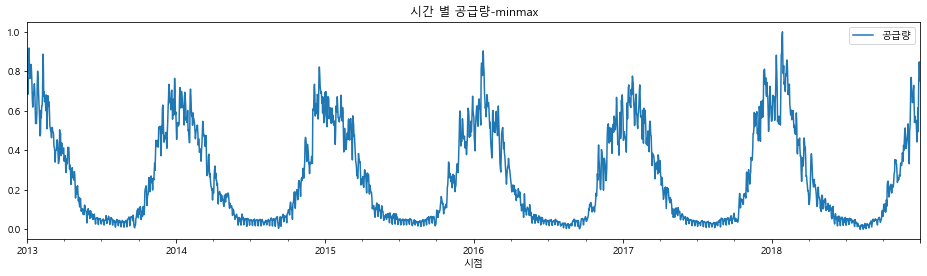

In [7]:
# 정규화 된 데이터 시각화
df_D0.plot(figsize=(16,4),legend=True)
plt.title('시간 별 공급량-minmax')
plt.show()

In [8]:
# LSTM에 들어갈 input data와 output data 형식에 맞게 생성해 주는 함수 정의
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[2000:]             
    y_test = y_train[2000:]
    
    X_train = X_train[:2000]           
    y_train = y_train[:2000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (2000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
            
    return [X_train, y_train, X_test, y_test]

In [9]:
# load_data함수에 의해 input과 output을 나누고 형식 확인
seq_len = 20

X_train, y_train, X_test, y_test = load_data(df_D0, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (2000, 20, 1)
y_train.shape =  (2000,)
X_test.shape =  (171, 20, 1)
y_test.shape =  (171,)


In [10]:
#LSTM 모델 학습
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.compile(optimizer="adam",loss="MAE")
lstm_model.fit(X_train, y_train, epochs=15, batch_size=1000)

lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test,lstm_predictions)

lstm_model.summary()

print("R2 Score of LSTM model = ",lstm_score)

Epoch 1/15
2/2 [==============================] - 3s 131ms/step - loss: 0.2350
Epoch 2/15
2/2 [==============================] - 0s 125ms/step - loss: 0.1719
Epoch 3/15
2/2 [==============================] - 0s 125ms/step - loss: 0.1213
Epoch 4/15
2/2 [==============================] - 0s 127ms/step - loss: 0.1043
Epoch 5/15
2/2 [==============================] - 0s 118ms/step - loss: 0.1102
Epoch 6/15
2/2 [==============================] - 0s 143ms/step - loss: 0.0878
Epoch 7/15
2/2 [==============================] - 0s 120ms/step - loss: 0.0759
Epoch 8/15
2/2 [==============================] - 0s 121ms/step - loss: 0.0765
Epoch 9/15
2/2 [==============================] - 0s 132ms/step - loss: 0.0723
Epoch 10/15
2/2 [==============================] - 0s 134ms/step - loss: 0.0626
Epoch 11/15
2/2 [==============================] - 0s 118ms/step - loss: 0.0666
Epoch 12/15
2/2 [==============================] - 0s 133ms/step - loss: 0.0694
Epoch 13/15
2/2 [==============================] 

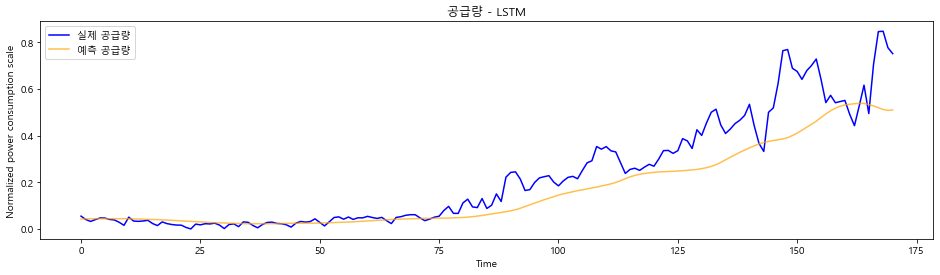

In [11]:
# 실제 값과 예측값 시각화
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='실제 공급량')
    plt.plot(predicted, alpha=0.7, color='orange',label='예측 공급량')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "공급량 - LSTM")

# 구분=D, hour=0 데이터 예측

In [12]:
# test에서 구분=D, hour=0인 데이터 추출
test_D0 = test[(test['구분'] == 'D') & (test.index.hour == 0)]
test_D0.drop(columns='구분', inplace=True)
test_D0

""
시점
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
...
2019-03-27
2019-03-28
2019-03-29


In [13]:
# 공급량은 null으로 생성
test_D0['공급량'] = np.nan
test_D0

,공급량
시점,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2019-03-27,NaN
2019-03-28,NaN
2019-03-29,NaN


In [14]:
# D0데이터에 train과 test결합
D0 = df_D0.append(test_D0)
D0

,공급량
시점,
2013-01-01,0.766965
2013-01-02,0.684169
2013-01-03,0.900226
2013-01-04,0.913686
2013-01-05,0.917757
...,...
2019-03-27,NaN
2019-03-28,NaN
2019-03-29,NaN


In [15]:
# NaN값을 순서대로 하나씩 계산
for i in range(len(test_D0)):
    pred = lstm_model.predict(np.reshape(np.array(D0.dropna()[len(D0.dropna())-20:]), (1, 20, 1)))
    D0.iloc[len(D0.dropna())] = pred

D0

,공급량
시점,
2013-01-01,0.766965
2013-01-02,0.684169
2013-01-03,0.900226
2013-01-04,0.913686
2013-01-05,0.917757
...,...
2019-03-27,0.181550
2019-03-28,0.178950
2019-03-29,0.176390


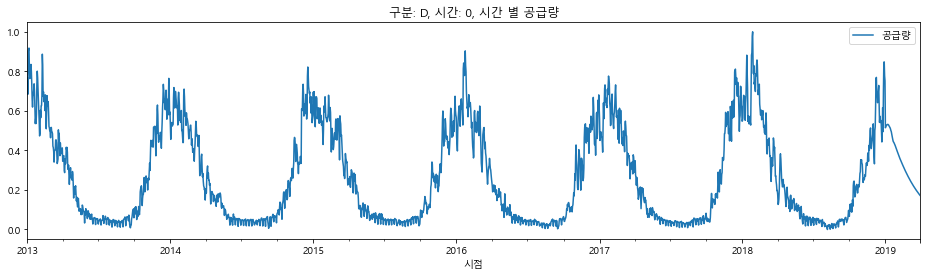

In [16]:
# 생성된 데이터 시각화
D0.plot(figsize=(16,4),legend=True)
plt.title('구분: D, 시간: 0, 시간 별 공급량')
plt.show()

In [17]:
# 위에서 생성한 scaler를 활용하여 scale 복원
D0['공급량'] = scaler.inverse_transform(D0)
D0

,공급량
시점,
2013-01-01,1434.516000
2013-01-02,1291.316000
2013-01-03,1664.996000
2013-01-04,1688.276000
2013-01-05,1695.316000
...,...
2019-03-27,422.016194
2019-03-28,417.518690
2019-03-29,413.090153
